# [Prophet Quick Start](https://facebook.github.io/prophet/docs/quick_start.html)

In [20]:
import pandas as pd; from fbprophet import Prophet
%matplotlib inline

In [50]:
df = pd.read_csv('data/example_wp_log_peyton_manning.csv')
df.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

In [51]:
# fit the model
m = Prophet(); m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.

In [52]:
# predict
future = m.make_future_dataframe(periods=365)
future.tail()

ds
3265 2017-01-15
3266 2017-01-16
3267 2017-01-17
3268 2017-01-18
3269 2017-01-19

- The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [53]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']]

ds      yhat  yhat_lower  yhat_upper
0    2007-12-10  8.845957    8.169057    9.462320
1    2007-12-11  8.594475    7.940246    9.218636
2    2007-12-12  8.390266    7.805270    8.997437
3    2007-12-13  8.368155    7.752099    8.953259
4    2007-12-14  8.356095    7.747167    8.948933
...         ...       ...         ...         ...
3265 2017-01-15  8.204125    7.508472    8.949846
3266 2017-01-16  8.529148    7.743864    9.237932
3267 2017-01-17  8.316555    7.630977    9.039165
3268 2017-01-18  8.149153    7.468114    8.847633
3269 2017-01-19  8.161075    7.407142    8.889096

[3270 rows x 4 columns]

- You can plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.

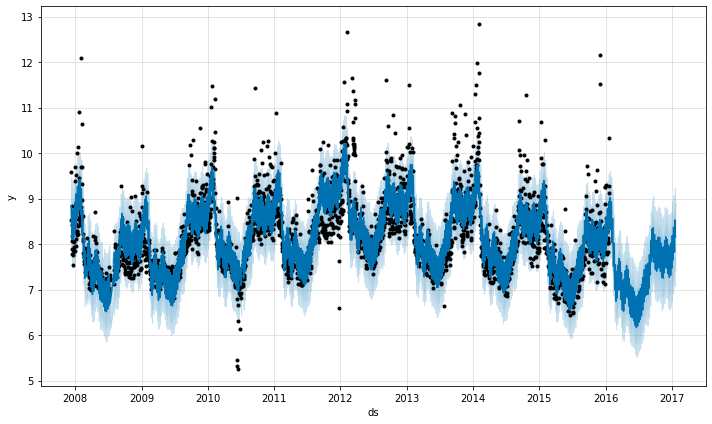

In [54]:
fig1 = m.plot(forecast)

- If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

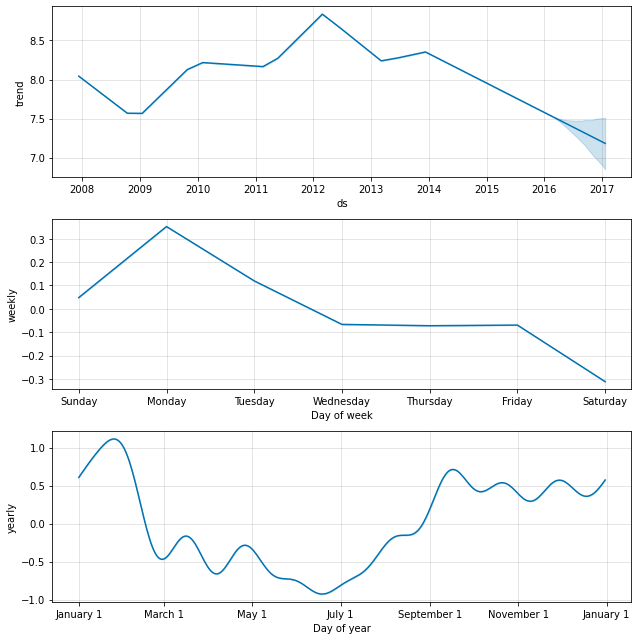

In [26]:
fig2 = m.plot_components(forecast)

- An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the notebook and ipywidgets packages.

In [27]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m,forecast)

In [28]:
plot_components_plotly(m,forecast)

# [Saturating Forecasts](https://facebook.github.io/prophet/docs/saturating_forecasts.html)

- By default, Prophet uses a linear model for its forecast. When forecasting growth, there is *usually some maximum achievable point: total market size, total population size*, etc. This is called the carrying capacity, and the forecast should saturate at this point.

Prophet allows you to make forecasts using a *logistic growth* trend model, with a specified carrying capacity. We illustrate this with the log number of page visits to the R (programming language) page on Wikipedia:

In [1]:
import pandas as pd; from fbprophet import Prophet
%matplotlib inline

In [2]:
df = pd.read_csv('~/scikit_learn_data/example_wp_log_R.csv')

- We must specify the carrying capacity in a column cap. Here we will assume a particular value, but this would usually be set using data or expertise about the market size.

- The cap must be specified for every row in the dataframe, and that it does not have to be constant. If the market size is growing, then cap can be an increasing sequence.

- We then fit the model as before, except pass in an additional argument to specify logistic growth:

In [3]:
df['cap'] = 8.5

In [4]:
m = Prophet(growth='logistic'); m.fit(df)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- We make a dataframe for future predictions as before, except we must also specify the capacity in the future. Here we keep capacity constant at the same value as in the history, and forecast 5 years into the future:

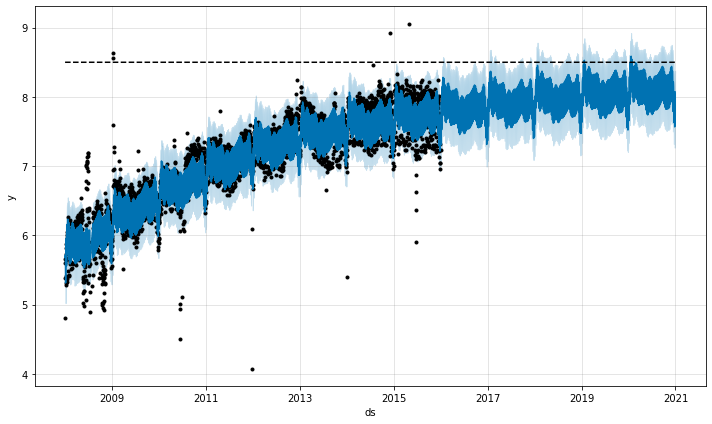

In [5]:
future = m.make_future_dataframe(periods=5*365)
future['cap'] = 8.5
fcst = m.predict(future)
fig = m.plot(fcst)

- The logistic function has an implicit minimum of 0, and will saturate at 0 the same way that it saturates at the capacity. It is possible to also specify a different saturating minimum.

## Saturating Minimum

- The logistic growth model can also handle a saturating minimum, which is specified with a column floor in the same way as the cap column specifies the maximum.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


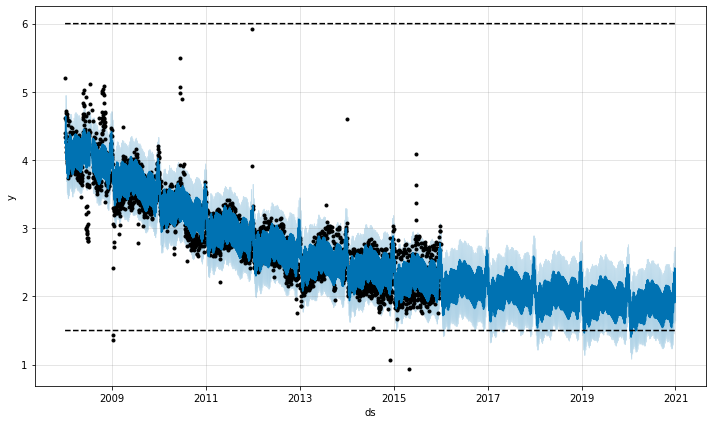

In [6]:
df['y']         = 10 - df['y']
df['cap'],     df['floor']       = 6, 1.5
future['cap'], future['floor']   = 6, 1.5
m = Prophet(growth='logistic')
m.fit(df)
fcst = m.predict(future)
fig = m.plot(fcst)

# [Trend Changepoints](https://facebook.github.io/prophet/docs/trend_changepoints.html)

- real time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use.

## Auto-detect

- Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible. Consider the Peyton Manning forecast from the Quickstart. By default, Prophet specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series. The vertical lines in this figure indicate where the potential changepoints were placed.

![here](px/trend_changepoints_4_0.png)

- Even though we have a lot of places where the rate can possibly change, because of the sparse prior, most of these changepoints go unused. We can see this by plotting the magnitude of the rate change at each changepoint:

![here](px/trend_changepoints_6_0.png)

- The number of potential changepoints can be set with `n_changepoints`, but this is better tuned by adjusting the regularization. The locations of the signification changepoints can be visualized.

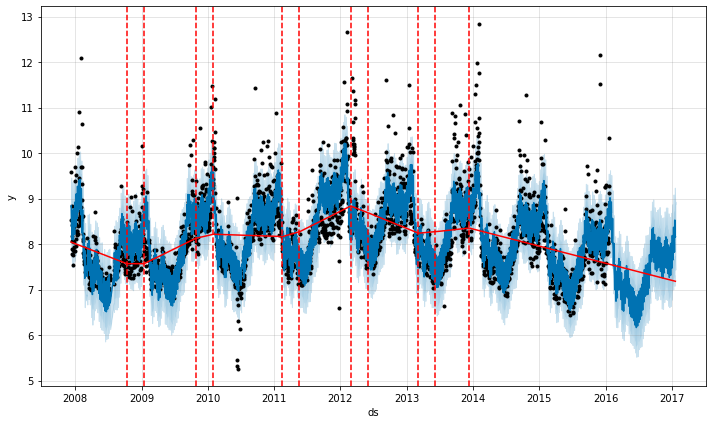

In [29]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),m,forecast)

- By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series. This default works in many situations but not all, and can be changed using the changepoint_range argument. For example, m = Prophet(changepoint_range=0.9) in Python or m <- prophet(changepoint.range = 0.9) in R will place potential changepoints in the first 90% of the time series.

## Adjusting trend flexibility

- If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


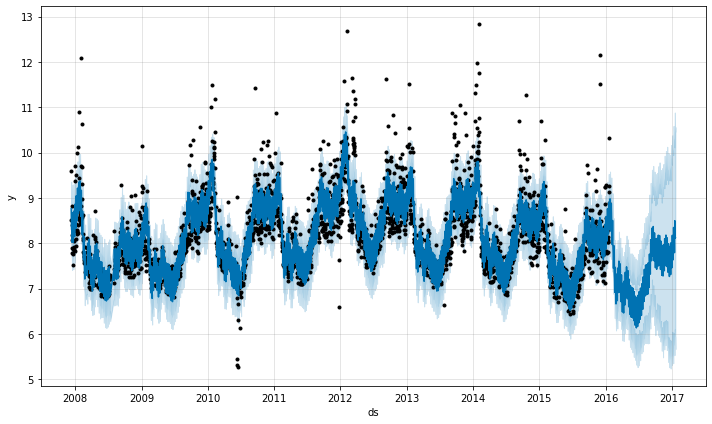

In [30]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

- Decreasing it will make the trend less flexible.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


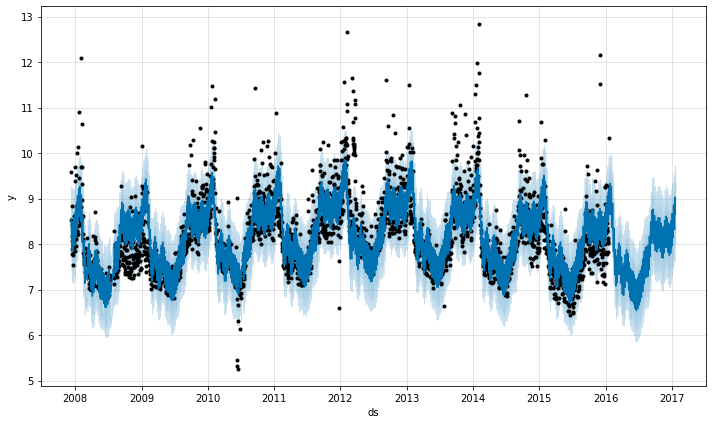

In [31]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

- When visualizing the forecast, this parameter can be adjusted as needed if the trend seems to be over- or under-fit. In the fully-automated setting, see the documentation on cross validation for recommendations on how this parameter can be tuned.

## Specifying changepoint locations

- If you wish, rather than using automatic changepoint detection you can manually specify the locations of potential changepoints with the changepoints argument. Slope changes will then be allowed only at these points, with the same sparse regularization as before. One could, for instance, create a grid of points as is done automatically, but then augment that grid with some specific dates that are known to be likely to have changes. As another example, the changepoints could be entirely limited to a small set of dates.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


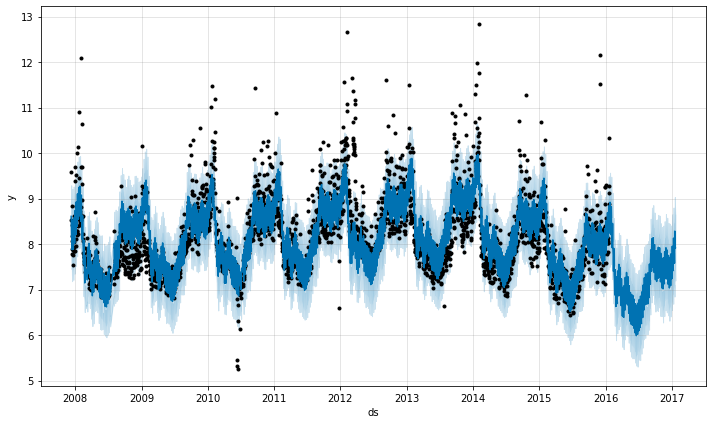

In [32]:
m = Prophet(changepoints=['2014-01-01'])
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

# [Seasonality, Holidays, Regressors](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html)

- If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them. It has two columns (holiday and ds) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won’t repeat in the future, Prophet will model them and then not include them in the forecast.

- You can also include columns lower_window and upper_window which extend the holiday out to [lower_window, upper_window] days around the date. For instance, if you wanted to include Christmas Eve in addition to Christmas you’d include lower_window=-1,upper_window=0. If you wanted to use Black Friday in addition to Thanksgiving, you’d include lower_window=0,upper_window=1. You can also include a column prior_scale to set the prior scale separately for each holiday, as described below.

- Here we create a dataframe that includes the dates of all of Peyton Manning’s playoff appearances.

In [33]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

- Above we have included the superbowl days as both playoff games and superbowl games. This means that the superbowl effect will be an additional additive bonus on top of the playoff effect.

- Once the table is created, holiday effects are included in the forecast by passing them in with the holidays argument. Here we do it with the Peyton Manning data from the Quickstart:

In [34]:
m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- The holiday effect can be seen in the forecast dataframe.

In [35]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

ds   playoff  superbowl
2190 2014-02-02  1.220720   1.214678
2191 2014-02-03  1.901618   1.460850
2532 2015-01-11  1.220720   0.000000
2533 2015-01-12  1.901618   0.000000
2901 2016-01-17  1.220720   0.000000
2902 2016-01-18  1.901618   0.000000
2908 2016-01-24  1.220720   0.000000
2909 2016-01-25  1.901618   0.000000
2922 2016-02-07  1.220720   1.214678
2923 2016-02-08  1.901618   1.460850

- The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl.

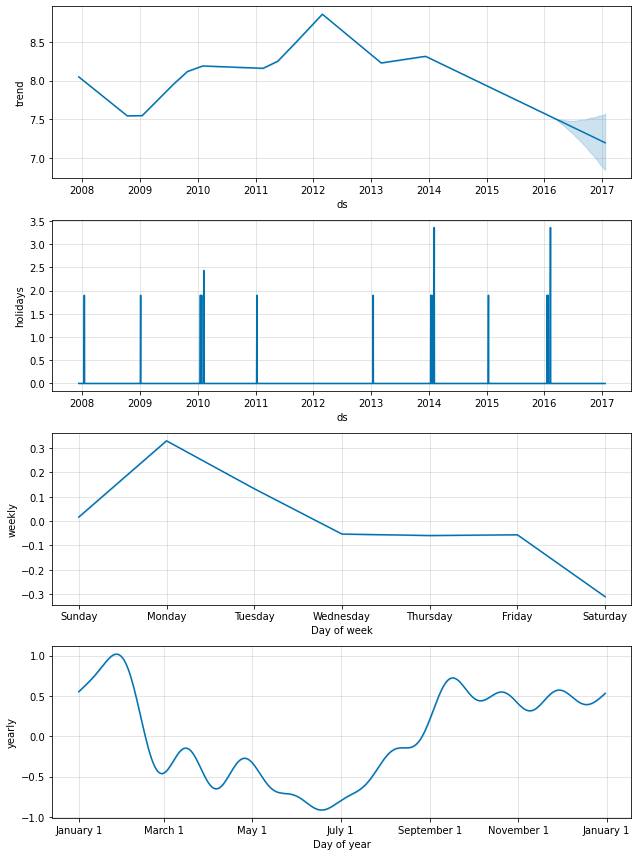

In [36]:
fig = m.plot_components(forecast)

- Individual holidays can be plotted using the plot_forecast_component function (imported from prophet.plot in Python) like plot_forecast_component(m, forecast, 'superbowl') to plot just the superbowl holiday component.

## Built-in country holidays

- You can use a built-in collection of country-specific holidays using the add_country_holidays method (Python) or function (R). The name of the country is specified, and then major holidays for that country will be included in addition to any holidays that are specified via the holidays argument described above.

In [37]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- You can see which holidays were included by looking at the train_holiday_names (Python) or train.holiday.names (R) attribute of the model.

In [38]:
m.train_holiday_names

0                         playoff
1                       superbowl
2                  New Year's Day
3      Martin Luther King Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7                       Labor Day
8                    Columbus Day
9                    Veterans Day
10                   Thanksgiving
11                  Christmas Day
12       Christmas Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
15      New Year's Day (Observed)
dtype: object

- The holidays for each country are provided by the holidays package in Python. A list of available countries, and the country name to use, is available on their page: https://github.com/dr-prodigy/python-holidays. In addition to those countries, Prophet includes holidays for these countries: Brazil (BR), Indonesia (ID), India (IN), Malaysia (MY), Vietnam (VN), Thailand (TH), Philippines (PH), Pakistan (PK), Bangladesh (BD), Egypt (EG), China (CN), and Russian (RU), Korea (KR), Belarus (BY), and United Arab Emirates (AE).

- In Python, most holidays are computed deterministically and so are available for any date range; a warning will be raised if dates fall outside the range supported by that country. In R, holiday dates are computed for 1995 through 2044 and stored in the package as data-raw/generated_holidays.csv. If a wider date range is needed, this script can be used to replace that file with a different date range: https://github.com/facebook/prophet/blob/master/python/scripts/generate_holidays_file.py.

- As above, the country-level holidays will then show up in the components plot

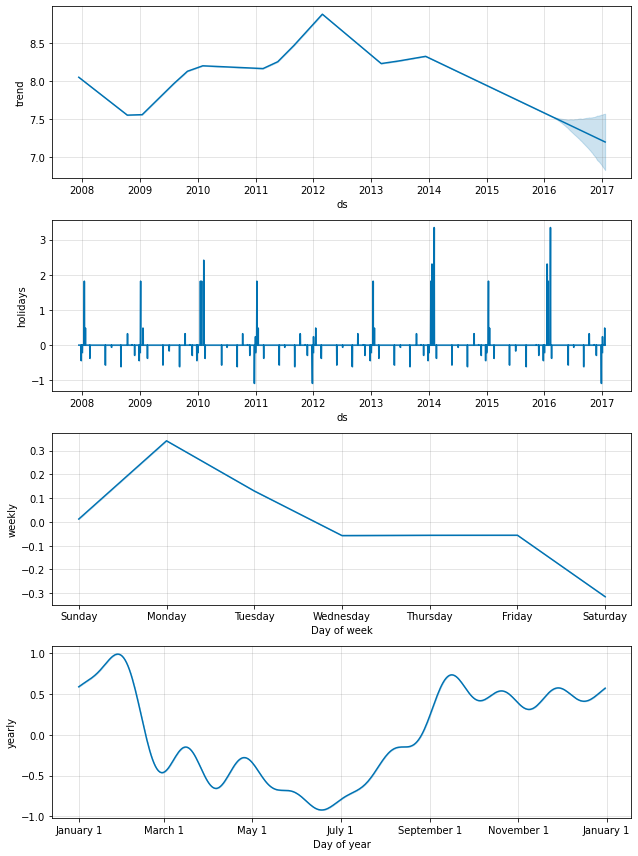

In [39]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

## Fourier order for seasonalities

- Seasonalities are estimated using a partial Fourier sum. See the paper for complete details, and this figure on Wikipedia for an illustration of how a partial Fourier sum can approximate an arbitrary periodic signal. The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change. To illustrate this, consider the Peyton Manning data from the Quickstart. The default Fourier order for yearly seasonality is 10, which produces this fit.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


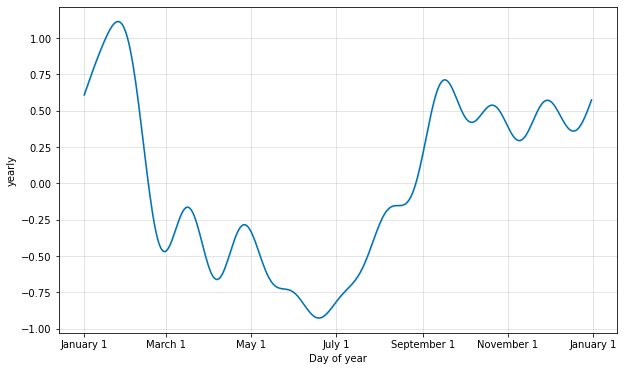

In [41]:
from fbprophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)

- The default values are often appropriate, but they can be increased when the seasonality needs to fit higher-frequency changes, and generally be less smooth. The Fourier order can be specified for each built-in seasonality when instantiating the model, here it is increased to 20.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


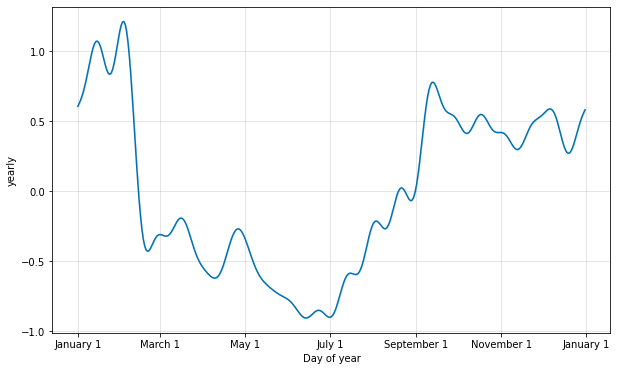

In [43]:
from fbprophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

- Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting: N Fourier terms corresponds to 2N variables used for modeling the cycle.

## Specifying custom seasonalities

- Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the add_seasonality method (Python) or function (R).

- The inputs to this function are a name, the period of the seasonality in days, and the Fourier order for the seasonality. For reference, by default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality. An optional input to add_seasonality is the prior scale for that seasonal component - this is discussed below.

- As an example, here we fit the Peyton Manning data from the Quickstart, but replace the weekly seasonality with monthly seasonality. The monthly seasonality then will appear in the components plot:

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


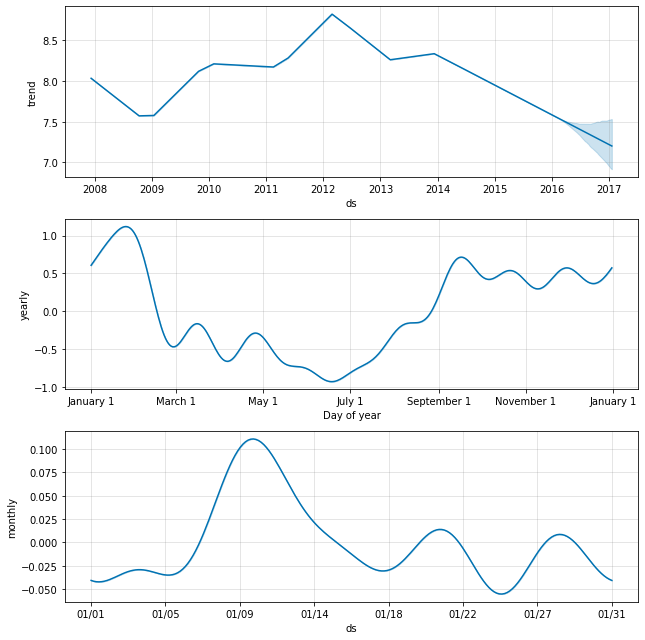

In [44]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

## Other seasonalities

- In some instances the seasonality may depend on other factors, such as a weekly seasonal pattern that is different during the summer than it is during the rest of the year, or a daily seasonal pattern that is different on weekends vs. on weekdays. These types of seasonalities can be modeled using conditional seasonalities.

- Consider the Peyton Manning example from the Quickstart. The default weekly seasonality assumes that the pattern of weekly seasonality is the same throughout the year, but we’d expect the pattern of weekly seasonality to be different during the on-season (when there are games every Sunday) and the off-season. We can use conditional seasonalities to construct separate on-season and off-season weekly seasonalities.

- First we add a boolean column to the dataframe that indicates whether each date is during the on-season or the off-season:

In [45]:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

df['on_season']  =  df['ds'].apply(is_nfl_season)
df['off_season'] = ~df['ds'].apply(is_nfl_season)

- Then we disable the built-in weekly seasonality, and replace it with two weekly seasonalities that have these columns specified as a condition. This means that the seasonality will only be applied to dates where the condition_name column is True. We must also add the column to the future dataframe for which we are making predictions.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


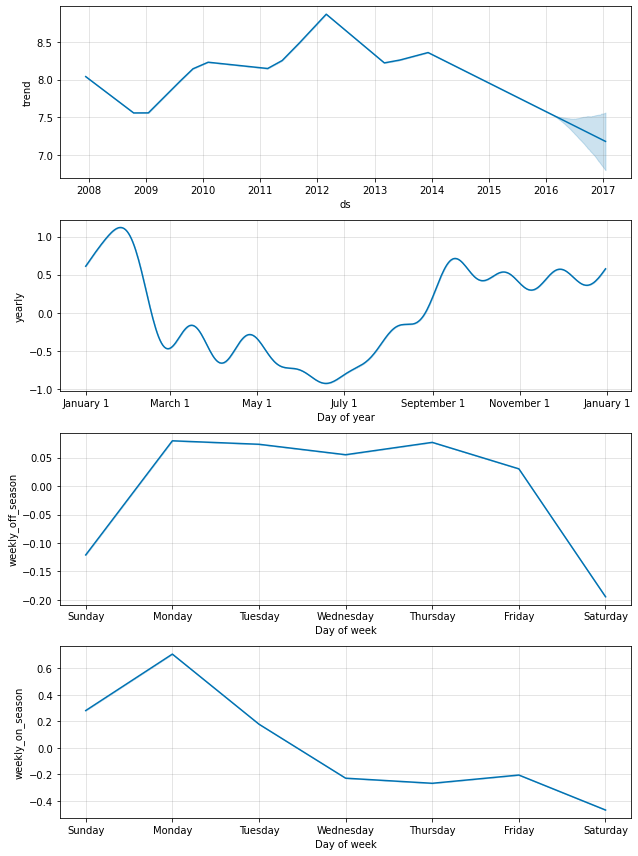

In [46]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season',  period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')

future['on_season']  =  future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)

forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

- Both of the seasonalities now show up in the components plots above. We can see that during the on-season when games are played every Sunday, there are large increases on Sunday and Monday that are completely absent during the off-season.

## Prior scale for holidays & seasonality

- If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using the parameter holidays_prior_scale. By default this parameter is 10, which provides very little regularization. Reducing this parameter dampens holiday effects.

In [47]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds   playoff  superbowl
2190 2014-02-02  1.206287   0.963118
2191 2014-02-03  1.852777   0.992788
2532 2015-01-11  1.206287   0.000000
2533 2015-01-12  1.852777   0.000000
2901 2016-01-17  1.206287   0.000000
2902 2016-01-18  1.852777   0.000000
2908 2016-01-24  1.206287   0.000000
2909 2016-01-25  1.852777   0.000000
2922 2016-02-07  1.206287   0.963118
2923 2016-02-08  1.852777   0.992788

- The magnitude of the holiday effect has been reduced compared to before, especially for superbowls, which had the fewest observations. There is a parameter seasonality_prior_scale which similarly adjusts the extent to which the seasonality model will fit the data.

- Prior scales can be set separately for individual holidays by including a column prior_scale in the holidays dataframe. Prior scales for individual seasonalities can be passed as an argument to add_seasonality. For instance, the prior scale for just weekly seasonality can be set using

In [48]:
m = Prophet()
m.add_seasonality(
    name='weekly', period=7, fourier_order=3, prior_scale=0.1)

## More regressors

- Additional regressors can be added to the linear part of the model using the add_regressor method or function. A column with the regressor value will need to be present in both the fitting and prediction dataframes. For example, we can add an additional effect on Sundays during the NFL season. On the components plot, this effect will show up in the ‘extra_regressors’ plo.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


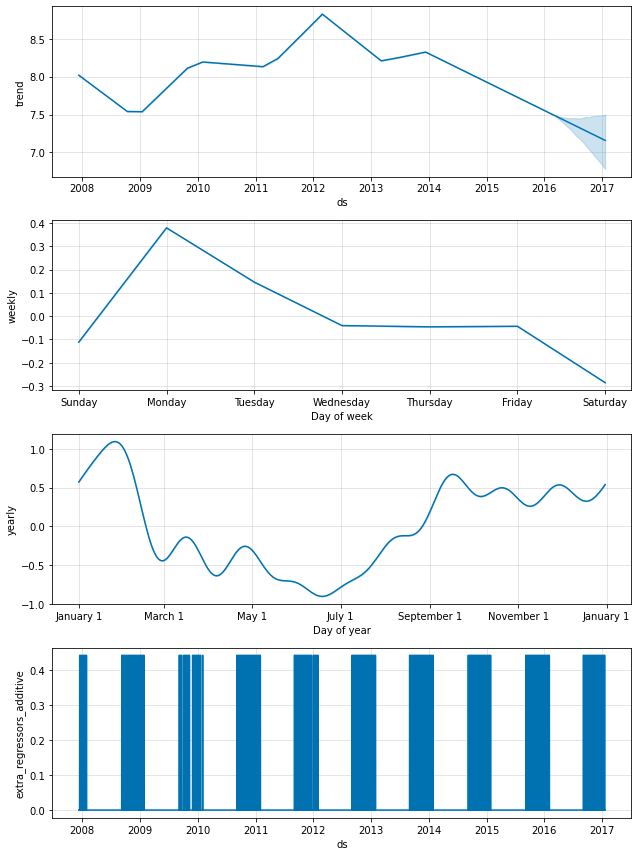

In [49]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
    
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
fig = m.plot_components(forecast)

- NFL Sundays could also have been handled using the “holidays” interface described above, by creating a list of past and future NFL Sundays. The add_regressor function provides a more general interface for defining extra linear regressors, and in particular does not require that the regressor be a binary indicator. Another time series could be used as a regressor, although its future values would have to be known.

- This notebook shows an example of using weather factors as extra regressors in a forecast of bicycle usage, and provides an excellent illustration of how other time series can be included as extra regressors.

- The add_regressor function has optional arguments for specifying the prior scale (holiday prior scale is used by default) and whether or not the regressor is standardized - see the docstring with help(Prophet.add_regressor) in Python and ?add_regressor in R. Note that regressors must be added prior to model fitting. Prophet will also raise an error if the regressor is constant throughout the history, since there is nothing to fit from it.

- The extra regressor must be known for both the history and for future dates. It thus must either be something that has known future values (such as nfl_sunday), or something that has separately been forecasted elsewhere. The weather regressors used in the notebook linked above is a good example of an extra regressor that has forecasts that can be used for future values. One can also use as a regressor another time series that has been forecasted with a time series model, such as Prophet. For instance, if r(t) is included as a regressor for y(t), Prophet can be used to forecast r(t) and then that forecast can be plugged in as the future values when forecasting y(t). A note of caution around this approach: This will probably not be useful unless r(t) is somehow easier to forecast then y(t). This is because error in the forecast of r(t) will produce error in the forecast of y(t). One setting where this can be useful is in hierarchical time series, where there is top-level forecast that has higher signal-to-noise and is thus easier to forecast. Its forecast can be included in the forecast for each lower-level series.

- Extra regressors are put in the linear component of the model, so the underlying model is that the time series depends on the extra regressor as either an additive or multiplicative factor (see the next section for multiplicativity).

## Additional regressors: coefficients

- To extract the beta coefficients of the extra regressors, use the utility function regressor_coefficients (from prophet.utilities import regressor_coefficients in Python, prophet::regressor_coefficients in R) on the fitted model. The estimated beta coefficient for each regressor roughly represents the increase in prediction value for a unit increase in the regressor value (note that the coefficients returned are always on the scale of the original data). If mcmc_samples is specified, a credible interval for each coefficient is also returned, which can help identify whether each regressor is “statistically significant”.

# Multiplicative Seasonality
- By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. This time series of the number of air passengers *is an example of when additive seasonality does not work.*

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


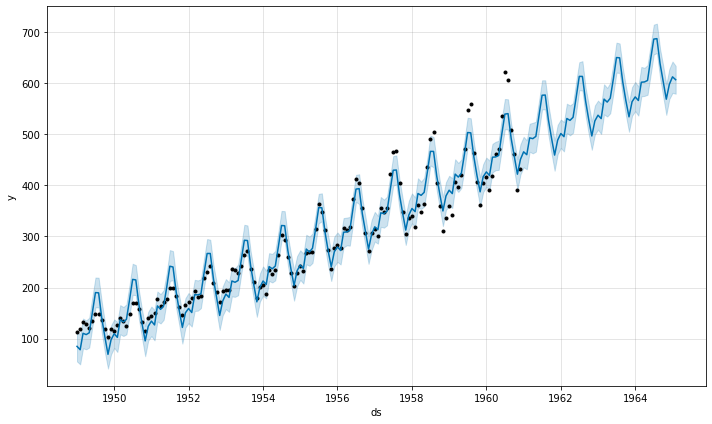

In [55]:
df = pd.read_csv('data/example_air_passengers.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

- This time series has a clear yearly cycle, but the seasonality in the forecast is too large at the start of the time series and too small at the end. 
- So the seasonality is *not a constant additive factor* as assumed by Prophet, rather it grows with the trend. This is *multiplicative seasonality.*
- Prophet can model multiplicative seasonality with `seasonality_mode='multiplicative'`.
- The components figure will now show seasonality *as a percent of the trend.*

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


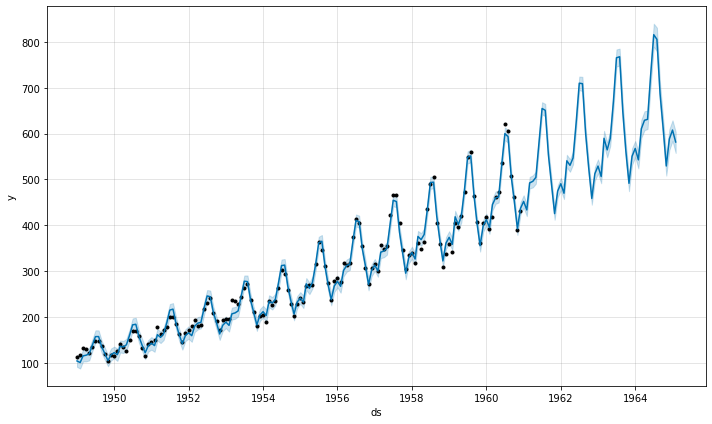

In [56]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)

/home/bjpcjp/anaconda3/envs/working/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



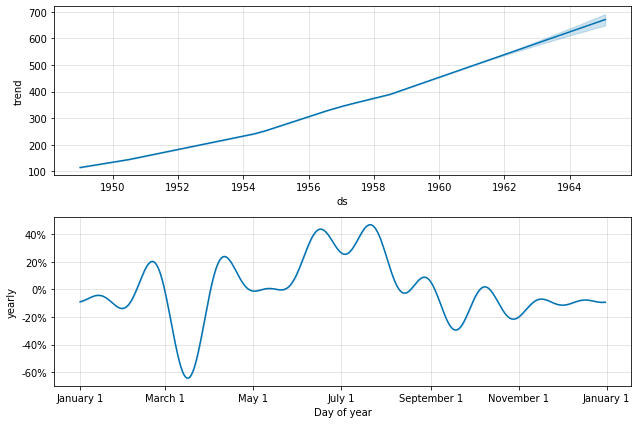

In [57]:
fig = m.plot_components(forecast)

- With `seasonality_mode='multiplicative'`, holiday effects will also be modeled as multiplicative. Any added seasonalities or extra regressors will by default use whatever seasonality_mode is set to, but can be overriden with `mode='additive'` or `mode='multiplicative'` when adding the seasonality or regressor.

- For example, this block sets the built-in seasonalities to multiplicative, but *includes an additive quarterly seasonality and an additive regressor*.

- Additive and multiplicative extra regressors will show up in separate panels on the components plot. 

- Note: it is unlikely to have a mix of additive and multiplicative seasonalities, so this should be used only if there is a reason to expect it.

In [58]:
m = Prophet(seasonality_mode='multiplicative')
m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
m.add_regressor('regressor', mode='additive')

# Uncertainty Intervals
- Prophet returns uncertainty intervals for `yhat`.
- 3 sources of uncertainty: 1) the trend, 2) seasonality, 3) other noise.

## Trend Uncertainty

- Trend changes = biggest source of forecast uncertainty. Prophet can detect & fit history changes. Going forward, the most reasonable approach is to assume *similar changes* in average frequency & magnitude. 

- `changepoint_prior_scale` enables allowing higher flexibility. If we model more rate changes in history, then we should expect more in the future. This makes uncertainty intervals useful indicators of overfitting.

- Below: setting an uncertainty interval width (default 80%) in `interval_width`.

- Assuming same change frequencies & magnitudes in the future is problematic. Don't expect accurate coverage.

In [59]:
forecast = Prophet(interval_width=0.95).fit(df).predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Seasonality uncertainty

- Prophet returns trend & noise uncertainty by default; you have to use *full Bayesian sampling* to get seasonality uncertainty. too.
- `mcmc.samples` (default: 0) controls this.
- It replaces the typical *MAP estimation* with *MCMC sampling* and can take much longer.
- You will then see seasonal component uncertainty in your plots when full sampling is used.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


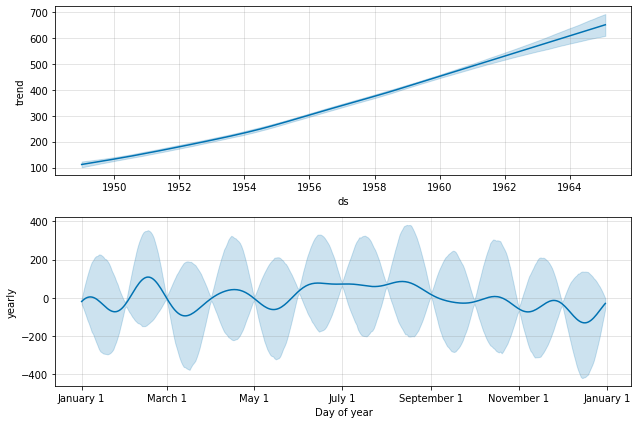

In [61]:
m = Prophet(mcmc_samples=300)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

- `m.predictive_samples(future)` returns the raw posterior predictive samples in Python.
- MCMC sampling in Windows is extremely slow (PyStan - upstream issues). Use Windows/R, or Linux/Python.

# Outliers
- Make a forecast of logged Wikipedia visits to the R page, but with a block of bad data.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


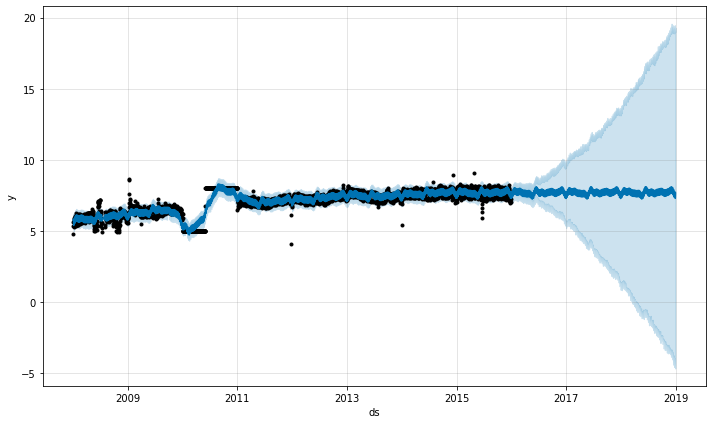

In [62]:
df = pd.read_csv('data/example_wp_log_R_outliers1.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)

- The trend forecast seems reasonable, but the uncertainties are way too wide. Prophet handles outliers by fitting them with trend changes. The uncertainty model expects future trend changes of similar magnitude.

- The best way to handle outliers is to remove them. Prophet has no problem with missing data. If you set missing values to NA (history) but leave dates in future, Prophet will predict them.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


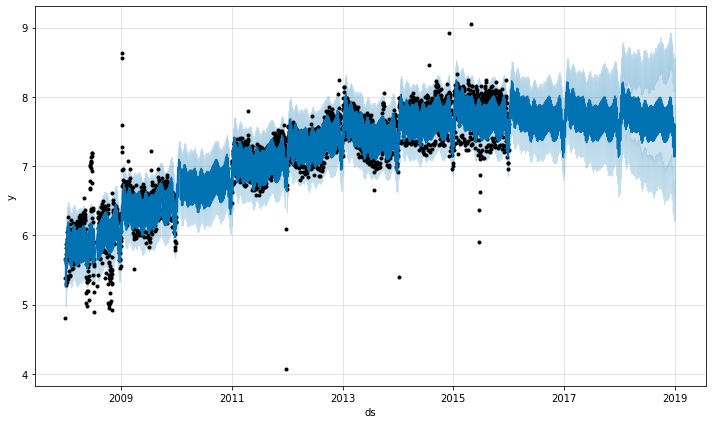

In [63]:
df.loc[(df['ds'] > '2010-01-01') & 
       (df['ds'] < '2011-01-01'), 'y'] = None
model = Prophet().fit(df)
fig = model.plot(model.predict(future))

- Above: the outliers messed up the uncertainty estimate, but did not impact the `yhat` (the main forecast). This isn't always the case (below):

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


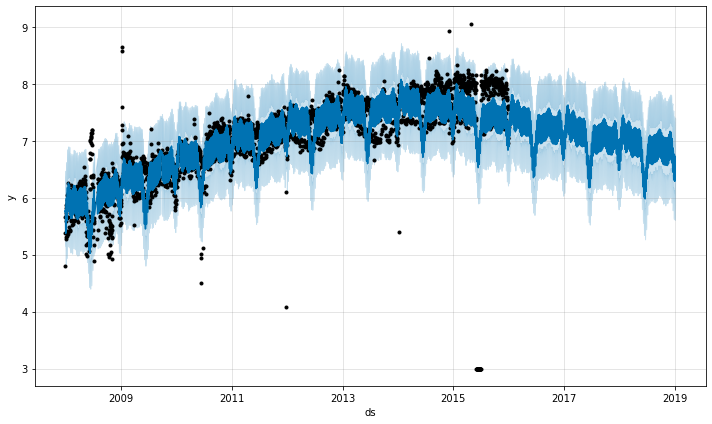

In [65]:
df = pd.read_csv('data/example_wp_log_R_outliers2.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)

- Here a group of outliers in June 2015 messes up the seasonality estimate, so their effect reverberates into the future. The right approach is to remove them.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


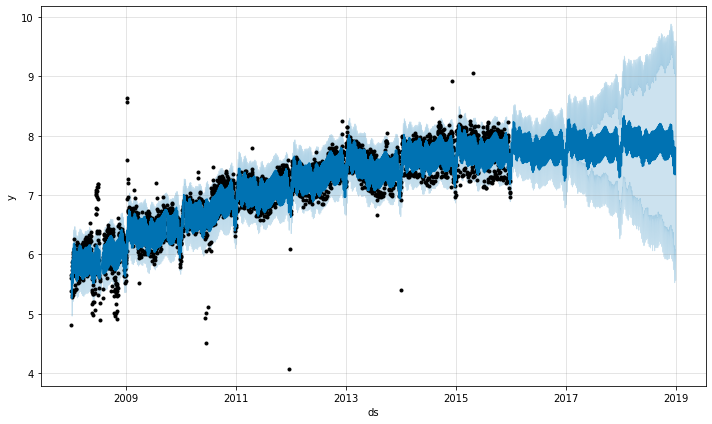

In [66]:
df.loc[(df['ds'] > '2015-06-01') & 
       (df['ds'] < '2015-06-30'), 'y'] = None
m = Prophet().fit(df)
fig = m.plot(m.predict(future))

# Non-Daily Data

- Prophet can make time series forecasts, with sub-daily observations, with a dataframe with timestamps in the `ds` column. The format is *YYYY-MM-DD HH:MM:SS`.
- Daily seasonality will automatically be fit when sub-daily data is used. Below: 5-minute resolution data.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


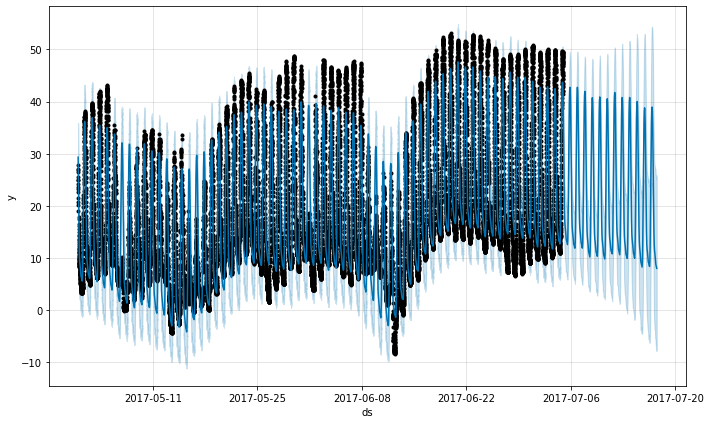

In [67]:
df = pd.read_csv('data/example_yosemite_temps.csv')
m = Prophet(changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

- Daily seasonality in the components plot:

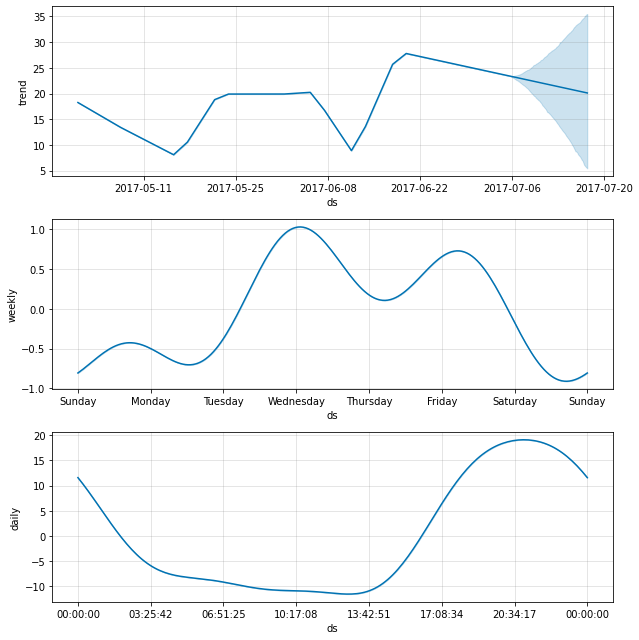

In [68]:
fig = m.plot_components(fcst)

## Data with regular gaps
- Below: data with observations only from 12am to 6am.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


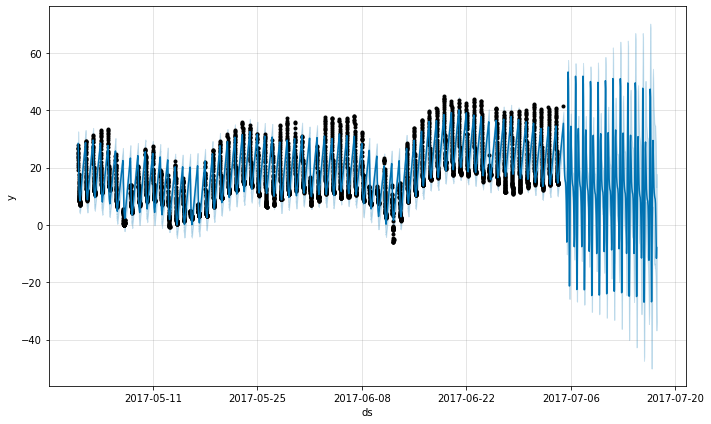

In [69]:
df2 = df.copy()
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2[df2['ds'].dt.hour < 6]
m = Prophet().fit(df2)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

- The forecast seems quite poor, with much larger fluctuations in the future. 
- We have fit a daily cycle to a time series that only has data for part of the day (12a to 6a). The daily seasonality is thus unconstrained for the remainder of the day and is not estimated well. 
- The solution is to only make predictions for the time windows for which there are historical data. Here, that means to limit the future dataframe to have times from 12a to 6a.

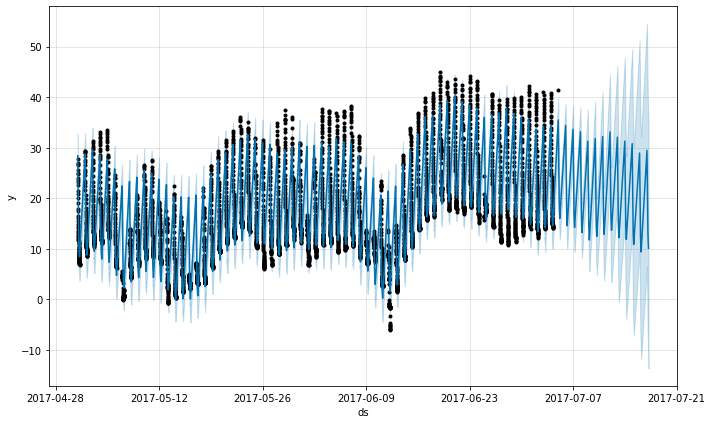

In [70]:
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour < 6]
fcst = m.predict(future2)
fig = m.plot(fcst)

## Monthly data
- You can use Prophet to fit monthly data. However, *the underlying model is continuous-time*, which means that you can get strange results if you fit the model to monthly data and then ask for daily forecasts. Here we forecast US retail sales volume for the next 10 years.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


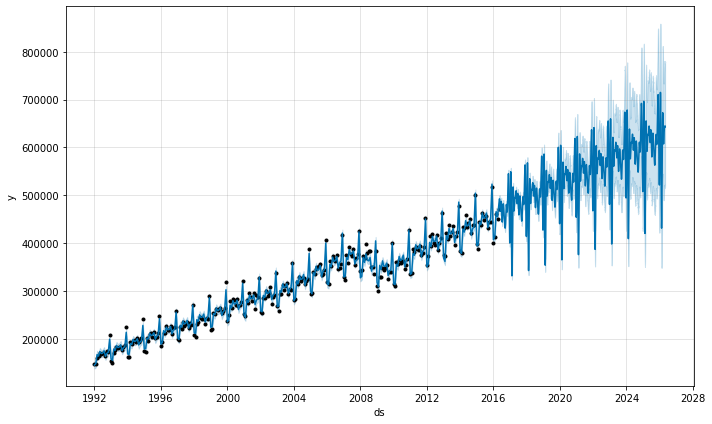

In [71]:
df = pd.read_csv('data/example_retail_sales.csv')
m = Prophet(seasonality_mode='multiplicative').fit(df)
future = m.make_future_dataframe(periods=3652)
fcst = m.predict(future)
fig = m.plot(fcst)

- Same issue as before: the dataset has regular gaps. Fitting for yearly seasonality only has data for the first of each month. This can be seen using *MCMC* to see the uncertainty.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/bjpcjp/anaconda3/envs/working/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



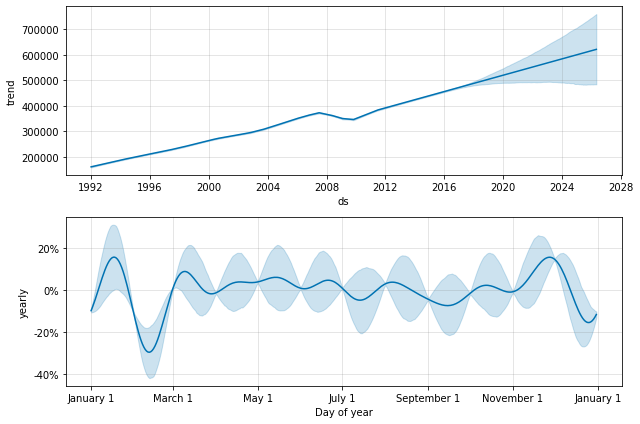

In [72]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(df)
fcst = m.predict(future)
fig = m.plot_components(fcst)

- The seasonality has low uncertainty at the start of each month where there are data points, but has very high posterior variance in between. 
- When fitting Prophet to monthly data, only make monthly forecasts, which can be done by passing the frequency into `make_future_dataframe`.

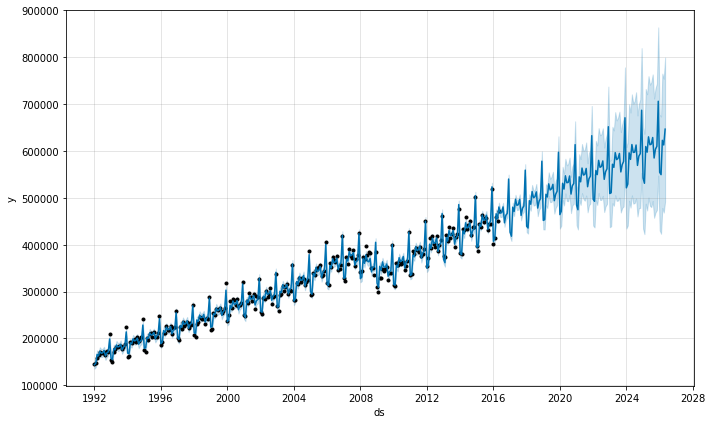

In [73]:
future = m.make_future_dataframe(periods=120, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

- In Python, the frequency can be anything from the pandas list of frequency strings here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases . Note that MS used here is month-start, meaning the data point is placed on the start of each month.

- In monthly data, yearly seasonality can also be modeled with binary extra regressors. The model can use 12 extra regressors like **is_jan, is_feb**, etc. where is_jan is 1 if the date is in Jan and 0 otherwise. This approach would avoid the within-month unidentifiability seen above. Be sure to use yearly_seasonality=False if monthly extra regressors are being added.

## Holidays with aggregated data

- Holiday effects are applied to the particular date on which the holiday was specified. With data that has been aggregated to weekly or monthly frequency, holidays that don’t fall on the particular date used in the data will be ignored: for example, a Monday holiday in a weekly time series where each data point is on a Sunday. To include holiday effects in the model, the holiday will need to be moved to the date in the history dataframe for which the effect is desired. Note that with weekly or monthly aggregated data, many holiday effects will be well-captured by the yearly seasonality, so added holidays may only be necessary for holidays that occur in different weeks throughout the time series.

# [Diagnostics](https://facebook.github.io/prophet/docs/diagnostics.html)

## Cross Validation

- Prophet offers *time series cross validation* to measure forecast error using historical data. 
- This is done by *selecting cutoff points* in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values. 
- Below: a simulated historical forecast on the Peyton Manning dataset, where the model was fit to a initial history of 5 years, and a forecast was made on a one year horizon.

![cv](px/diagnostics_4_0.png)

- CV can be done automatically for a range of historical cutoffs using `cross_validation()`. We specify the forecast horizon (horizon), then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to 3X the horizon, and cutoffs are every 1/2 horizon.

- CV returns a dataframe with the true values y and the out-of-sample forecast values yhat for each simulated forecast date and each cutoff date. A forecast is made for every observed point between cutoff and cutoff + horizon. This dataframe can then be used to compute error measures of yhat vs. y.

- Below: CV to assess prediction performance on a horizon of 365 days, starting with 730 days of training data in the first cutoff and then making predictions every 180 days. On this 8 year time series, this corresponds to 11 total forecasts.

In [75]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, 
                         initial='730 days', 
                         period='180 days', 
                         horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 44 forecasts with cutoffs between 1994-02-21 00:00:00 and 2015-05-02 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


ds           yhat     yhat_lower     yhat_upper       y     cutoff
0 1994-03-01  182695.660199  163805.386863  201353.418805  192319 1994-02-21
1 1994-04-01  186887.652663  166605.991151  207679.721174  189569 1994-02-21
2 1994-05-01  196529.319926  175087.596122  213989.087589  194927 1994-02-21
3 1994-06-01  186962.171129  167622.749564  207896.245071  197946 1994-02-21
4 1994-07-01  197459.581066  176065.123712  218907.417734  193355 1994-02-21

- In R: `units` must be a type accepted by as.difftime, which is weeks or shorter. In Python, the string for initial, period, and horizon should be in the format used by Pandas Timedelta, which accepts units of days or shorter.

- Custom cutoffs can be supplied as a list of dates to the `cutoffs` in `cross_validation()`. For example, three cutoffs six months apart, would need to be passed to the cutoffs argument in a date format like:

In [76]:
cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')


- The `performance_metrics` utility returns statistics of the prediction performance (`yhat`, `yhat_lower`, and `yhat_upper` compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). 
- The statistics computed are *mean squared error* (MSE), *root mean squared error* (RMSE), *mean absolute error* (MAE), *mean absolute percent error* (MAPE), *median absolute percent error* (MDAPE) and *coverage* of the yhat_lower and yhat_upper estimates. 
- These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with `rolling_window`.

In [78]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse          rmse          mae      mape     mdape  \
0 38 days  1.369496e+08  11702.546049  8579.370755  0.025804  0.020048   
1 39 days  1.428644e+08  11952.587730  8689.115870  0.025939  0.018370   
2 40 days  1.453324e+08  12055.387996  8829.401341  0.026519  0.020048   
3 42 days  1.448301e+08  12034.538483  8746.826078  0.026154  0.018370   
4 43 days  1.514972e+08  12308.421282  8955.556457  0.026874  0.018370   

   coverage  
0  0.557692  
1  0.557692  
2  0.538462  
3  0.557692  
4  0.551282

- CV performance metrics can be visualized with `plot_cross_validation_metric`, here shown for *MAPE*. 
- Dots show the absolute percent error for each prediction in df_cv. 
- The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. 
- This forecast shows errors ~5% are typical for predictions one month into the future, and that errors increase to ~11% for predictions that are a year out.

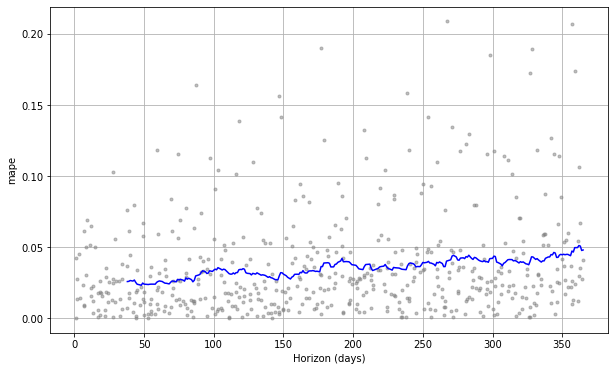

In [80]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

- The size of the rolling window can be changed with `rolling_window` which specifies the proportion of forecasts to use in each rolling window (default is 0.1, corresponding to 10% of rows from `df_cv` included in each window; increasing this will lead to a smoother average curve in the figure.) The initial period should be long enough to capture all of the components of the model, in particular seasonalities and extra regressors: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.

## Parallelizing CV

- `parallel=None`: default
- `parallel="processes"`: use for most problems; highest performance on a single machine.
- `parallel="threads"`
- `parallel="dask"`: for running large-problem jobs on a cluster. Dask must be installed separately.

In [82]:
from dask.distributed import Client
client = Client()  # connect to the cluster
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days',

                         parallel="dask")

INFO:fbprophet:Making 44 forecasts with cutoffs between 1994-02-21 00:00:00 and 2015-05-02 00:00:00
/home/bjpcjp/anaconda3/envs/working/lib/python3.8/site-packages/distributed/protocol/pickle.py:49: UserWarning:

Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.

/home/bjpcjp/.local/lib/python3.8/site-packages/cloudpickle/cloudpickle_fast.py:563: UserWarning:

Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.

INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38073' processes=4 threads=12, memory=15.55 GiB>


UnboundLocalError: local variable 'pool' referenced before assignment

## Hyperparameter tuning
- CV can be used for tuning model hyperparameters such as `changepoint_prior_scale` and `seasonality_prior_scale`. A Python example is given below, with a 4x4 grid of those two parameters, with parallelization over cutoffs. Here parameters are evaluated on RMSE averaged over a 30-day horizon, but different performance metrics may be appropriate for different problems.

In [83]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1,  0.5],
    'seasonality_prior_scale': [0.01,  0.1,  1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f311bfda4f0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f311bc811f0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f311bfda4f0>
INFO:fbprophet:Disabling weekly seaso

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01   8272.941679
1                     0.001                     0.10   9564.057310
2                     0.001                     1.00   7085.089774
3                     0.001                    10.00   7744.825604
4                     0.010                     0.01  15702.056037
5                     0.010                     0.10  15956.130263
6                     0.010                     1.00  15808.596423
7                     0.010                    10.00  16276.616108
8                     0.100                     0.01  11789.239122
9                     0.100                     0.10  11566.038460
10                    0.100                     1.00  11406.146124
11                    0.100                    10.00  11593.532806
12                    0.500                     0.01  12025.696495
13                    0.500                     0.10  11955.13

In [84]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}


## Tunable parameters
- `changepoint_prior_scale`: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.

- `seasonality_prior_scale`: This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

- `holidays_prior_scale`: This controls flexibility to fit holiday effects. Similar to seasonality_prior_scale, it defaults to 10.0 which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of [0.01, 10] as with seasonality_prior_scale.

- `seasonality_mode`: Options are ['additive', 'multiplicative']. Default is 'additive', but many business time series will have multiplicative seasonality. This is best identified just from looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series (see the documentation here on multiplicative seasonality), but when that isn’t possible, it could be tuned.

## Params that Probably don't need tuning

- `growth`: Options are ‘linear’ and ‘logistic’. This likely will not be tuned; if there is a known saturating point and growth towards that point it will be included and the logistic trend will be used, otherwise it will be linear.

- `changepoints`: This is for manually specifying the locations of changepoints. None by default, which automatically places them.

- `n_changepoints`: This is the number of automatically placed changepoints. The default of 25 should be plenty to capture the trend changes in a typical time series (at least the type that Prophet would work well on anyway). Rather than increasing or decreasing the number of changepoints, it will likely be more effective to focus on increasing or decreasing the flexibility at those trend changes, which is done with changepoint_prior_scale.

- `yearly_seasonality`: By default (‘auto’) this will turn yearly seasonality on if there is a year of data, and off otherwise. Options are [‘auto’, True, False]. If there is more than a year of data, rather than trying to turn this off during HPO, it will likely be more effective to leave it on and turn down seasonal effects by tuning seasonality_prior_scale.

- `weekly_seasonality`: Same as for yearly_seasonality.

- `daily_seasonality`: Same as for yearly_seasonality.

- `holidays`: This is to pass in a dataframe of specified holidays. The holiday effects would be tuned with holidays_prior_scale.

- `mcmc_samples`: Whether or not MCMC is used will likely be determined by factors like the length of the time series and the importance of parameter uncertainty (these considerations are described in the documentation).

- `interval_width`: Prophet predict returns uncertainty intervals for each component, like yhat_lower and yhat_upper for the forecast yhat. These are computed as quantiles of the posterior predictive distribution, and `interval_width` specifies which quantiles to use. The default of 0.8 provides an 80% prediction interval. You could change that to 0.95 if you wanted a 95% interval. This will affect only the uncertainty interval, and will not change the forecast yhat at all and so does not need to be tuned.

- `uncertainty_samples`: The uncertainty intervals are computed as quantiles from the posterior predictive interval, and the posterior predictive interval is estimated with Monte Carlo sampling. This parameter is the number of samples to use (defaults to 1000). The running time for predict will be linear in this number. Making it smaller will increase the variance (Monte Carlo error) of the uncertainty interval, and making it larger will reduce that variance. So, if the uncertainty estimates seem jagged this could be increased to further smooth them out, but it likely will not need to be changed. As with interval_width, this parameter only affects the uncertainty intervals and changing it will not affect in any way the forecast yhat; it does not need to be tuned.

- `stan_backend`: If both pystan and cmdstanpy backends set up, the backend can be specified. The predictions will be the same, this will not be tuned.


# Saving Models
- In Python, models should not be saved with pickle; the Stan backend attached to the model object will not pickle well, and will produce issues under certain versions of Python. Instead, you should use the built-in serialization functions to serialize the model to json.

In [89]:
import json
from fbprophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

with open('serialized_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model

ValueError: This can only be used to serialize models that have already been fit.

# Flat & Custom Trends
- For time series that exhibit strong seasonality patterns rather than trend changes, it may be useful to force the trend growth rate to be flat. This can be done with `growth=flat` when creating the model:

In [87]:
m = Prophet(growth="flat")

- If this is used on a time series that doesn’t have a constant trend, any trend will be fit with the noise term and so there will be high predictive uncertainty in the forecast.

- To use a trend besides these three built-in trend functions (`piecewise linear`, `piecewise logistic growth`, and `flat`), you can download the source code from github, modify the trend function as desired in a local branch, and then install that local version.

# Updating Fitted Models
- A common use case is fitting models that need to be updated as additional data come in. Prophet models can only be fit once, and a new model must be re-fit when new data become available. 
- In most settings, model fitting is fast enough that there isn’t any issue with re-fitting from scratch. However, it is possible to speed things up by `warm-starting` the fit from the model parameters of the earlier model. 

In [88]:
def stan_init(m):
    """Retrieve parameters from a trained model.
    
    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.
    
    Parameters
    ----------
    m: A trained model of the Prophet class.
    
    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

df = pd.read_csv('data/example_wp_log_peyton_manning.csv')
df1 = df.loc[df['ds'] < '2016-01-19', :]  # All data except the last day
m1 = Prophet().fit(df1) # A model fit to all data except the last day


%timeit m2 = Prophet().fit(df)  # Adding the last day, fitting from scratch
%timeit m2 = Prophet().fit(df, init=stan_init(m1))  # Adding the last day, warm-starting from m1


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

1.02 s ± 3.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


550 ms ± 4.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- The parameters from the previous model are passed in to the fitting for the next with the kwarg init. The speedup will depend on how much the optimal model parameters have changed with the addition of the new data.

- Caveats when considering warm-starting:
    - First, warm-starting may work well for small updates to the data but can be worse than fitting from scratch if there are large changes. This is because when a large amount of history is added, the location of the changepoints will be very different between the two models, and so the parameters from the previous model may actually produce a bad trend initialization. 
    - Second, the #changepoints need to be consistent from one model to the next or else an error will be raised because the changepoint prior parameter delta will be the wrong size.

# References
- [forecastr](https://github.com/garethcull/forecastr) - Web app UI for Prophet.
- [NeuralProphet](https://github.com/ourownstory/neural_prophet) - Prophet in pytorch.

# Resources